## Implementing Vanilla Attention from Scratch


- Vanilla Attention is the original/first form of attention mechanism introduced in Seq2Seq Models, for tasks like Machine Translation and Text Summarization.

- **Purpose**: It enables the model to selectively focus on relevant parts of the input sequence when producing each element of the output, rather than encoding the input into a single fixed-length context vector.

- **Mechanism**:
- **1.** For every output step, the Decoder calculates attention_weights(learned_weights) over all Encoder hidden states based on their relevance to the current decoding state.

- **2.** These weights are calculated by comparing a *Query* (from the Decoder) with *Keys* (from the Encoder) using a similarity function (commonly a dot-product).

- **3.** Attention scores are then passed through a *Softmax()* to convert to a probability distribution.

- **4.** The output(a Context-vector) is a weighted sum[i.e Multiplying each vector (*Value*) by a scalar (attention_weight) and adding up all those vectors] of the *Values*(from Encoder state), where weights reflect relevance to the current target step

![vanilla_attn.png](./imgs/vanilla_attn.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class VanillaAttention(nn.Module):
    def __init__(self, Dk=256):
        super().__init__()
        
        self.Dim_k = Dk
        
        #Scale the Dim_k to Sqrt(Dim_k) so that the variance remains roughly constant, otherwise logits gets too big
        self.scale = torch.sqrt(torch.tensor(Dk, dtype=torch.float32))
        
        #Linear Porjections that map Input--->query,key,value vectors
        self.wq = nn.Linear(Dk, Dk) #query Projection
        self.wk = nn.Linear(Dk, Dk) #key Projection
        self.wv = nn.Linear(Dk, Dk) #value Projection
        self.wo = nn.Linear(Dk,Dk)  #final output Projection
        
    def forward(self, x:torch.Tensor): 
        print(x.shape) #Shape: [B,S,D]====[Batch_dim, Seq_Len, Hidden Dim]
        Q,K,V = self.wq(x), self.wk(x), self.wv(x)
        
        #Compute Attention weights between each position 
        attn_weights = (Q @ K.transpose(1, 2))  #Shape: [B,S,D] @ [B,D,S]----->[B,S,S]
        
        #Scale the attn_weigths to prevent softmax saturation which would kill gradients
        attn_weights = attn_weights / self.scale
        
        #Compute Attention_scores
        attn_scores = F.softmax(attn_weights, dim= - 1)
        
        #Compute the weighted sum of Values based on attention_probs
        output  = self.wo(attn_scores @ V)
        return output, attn_scores

In [ ]:
#Dummy Inputs
batch_size, seq_len, hidden_dim = 1,20,256
x = torch.randn(batch_size,seq_len, hidden_dim)

attn = VanillaAttention(Dk=hidden_dim)

#Project the input through the Network
out, _ = attn(x)

assert out.shape == (batch_size,seq_len, hidden_dim); f"Expected Shape {(batch_size, seq_len, hidden_dim)} but got {out.shape}"
print("="*30,f"Output_Shape:{out.shape}","="*30 )
print("="*30, f"Input Shape:{x.shape}", "="*30)

torch.Size([1, 20, 256])
============================== Output_Shape:torch.Size([1, 20, 256]) ==============================
============================== Input Shape:torch.Size([1, 20, 256]) ==============================


torch.Size([1, 20, 256])


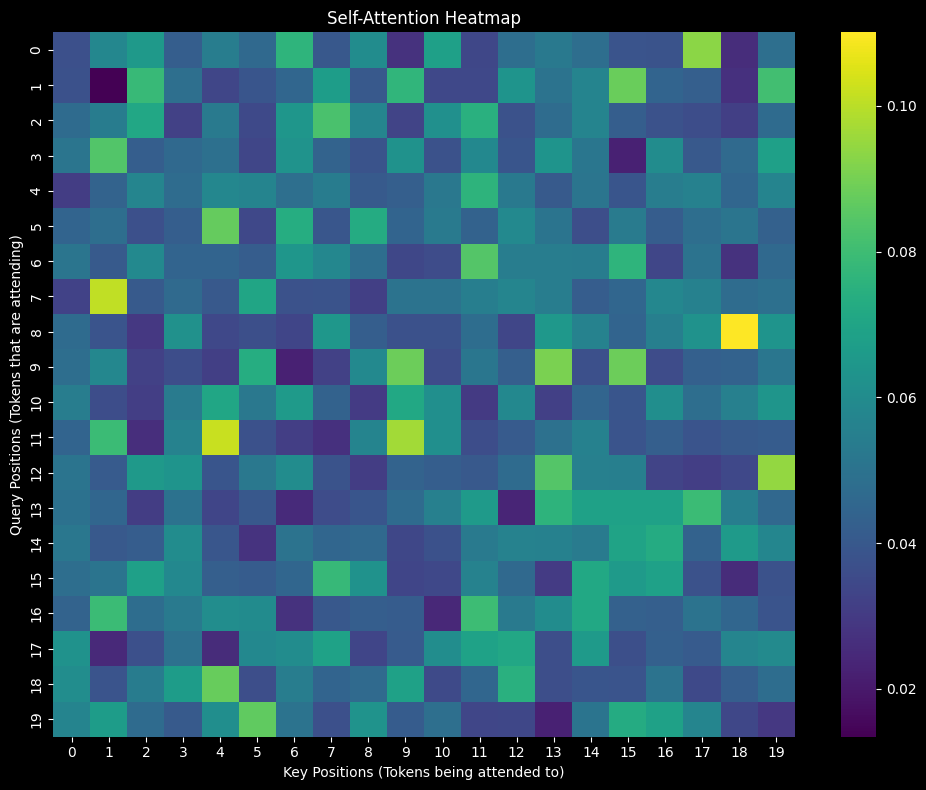

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

batch_size, seq_len, hidden_dim = 1,20,256
#Set model to Evaluation
model = VanillaAttention(Dk=hidden_dim)
model.eval()

dummy_input = torch.randn(batch_size, seq_len, hidden_dim)
with torch.no_grad():
    output, attn_scores = model(dummy_input)
    
attention_to_plot = attn_scores[0].cpu().numpy()
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(attention_to_plot, cmap='viridis', ax = ax)

ax.set_xlabel("Key Positions (Tokens being attended to)")
ax.set_ylabel("Query Positions (Tokens that are attending)")
ax.set_title("Self-Attention Heatmap")
plt.tight_layout()
plt.show()
